# Machine learning model using the Titanic dataset

It provides information on the fate of passengers on the Titanic summarized according to economic status, sex and age. In this challenge, we should answer the question whether a passenger on the titanic would have been survived or not.

 #### Project from https://www.kaggle.com

In [2]:
import numpy as np 

import pandas as pd 

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import cross_validation, metrics

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings(action='once')

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [4]:
#sex_avg = train_df.pivot_table(values='Age', index='Sex')
#train_df['Sex_MeanRatio'] = train_df.apply(lambda x: x['Age']/sex_avg.loc[x['Sex']], axis=1)
#train_df.columns

### It is always a good idea to start by exploring the data

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### The training set has 891 samples and 11 features plus the target variable 'Survived'. The test set has 418 samples.

#### Now we can take a look at the first entries:

In [7]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


#### We can see that we need to convert some features into numeric ones and deal with NaN values. Features with a wide range should be normalized.

#### Some statistics about our training set:

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 38% of the training set survived. Here we can also detect some potential issues, like missing values in 'Age'.

#### A more quantitative look into what is missing:

In [9]:
total = train_df.isna().sum().sort_values(ascending=False)
percent = (train_df.isna().sum()/train_df.isna().count()*100).round(decimals=1).sort_values(ascending=False)
missing_data = pd.concat([total, percent,], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


#### Since most entries for Cabin are empty, we might discart it from the analysis.

#### Time to look for features that correlate with the survival rate. Let's start with age and sex:

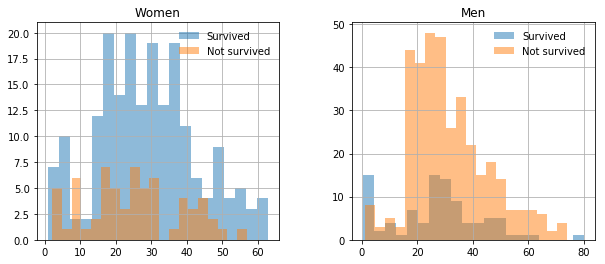

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

w_surv = women[women['Survived']==1]
w_notsurv = women[women['Survived']==0]

w_surv.hist(column='Age', ax = axes[0], bins = 20, label = 'Survived', alpha=0.5)
w_notsurv.hist(column='Age', ax = axes[0], bins = 20, label = 'Not survived', alpha=0.5)
axes[0].legend(frameon=False, fontsize = 'medium')
axes[0].set_title('Women')
axes[0].set_ylim(0, 21)

m_surv = men[men['Survived']==1]
m_notsurv = men[men['Survived']==0]

m_surv.hist(column='Age', ax = axes[1], bins = 20, label = 'Survived', alpha=0.5)
m_notsurv.hist(column='Age', ax = axes[1], bins = 20, label = 'Not survived', alpha=0.5)
axes[1].legend(frameon=False, fontsize = 'medium')
_ = axes[1].set_title('Men')
#axes[1].set_ylim(0, 50)

We can see that women have a high probability of survival between the ages 15 to 40, while for men this range is narrower. Infants also have a higher chance to survive for both genders.  

#### Now let's look for correlations between survival, embarked and class:

/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python2.7/dist-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


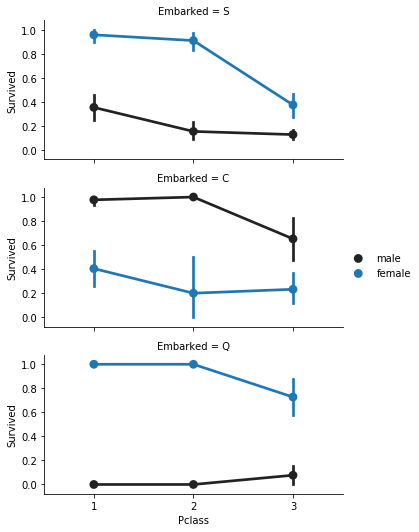

In [11]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=2.5, aspect=2)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
FacetGrid.add_legend();

Embarked shows a correlation with survival and gender. Women have a higher survival chance if embarked on ports S or Q, while men shows a better chance of surviving if embarked on port C. Pclass also shows a trend, so let's have a closer look at this feature:

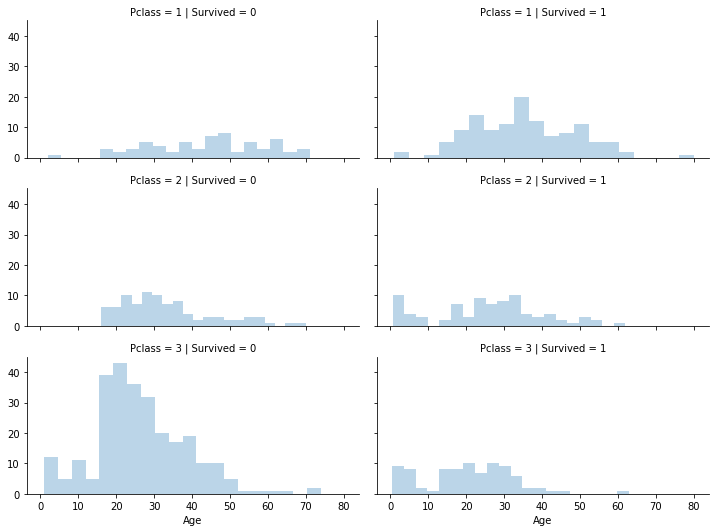

In [12]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.5, aspect=2)
grid.map(plt.hist, 'Age', alpha=0.3, bins=20)
grid.add_legend();

From the plot above we see that the probability of surviving is high for Pclass = 1, while for Pclass = 3 it is most likely that a person will not survive.

The total number of relatives a person has onboard is derived by combining SibSp and Parch. Below we create this feature and also another one that sows if someone is not alone.

In [13]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'alone'] = 1
    dataset['alone'] = dataset['alone'].astype(int)

In [14]:
train_df['alone'].value_counts()

1    537
0    354
Name: alone, dtype: int64

Let's take a look at the survival rate as a function of the number of relatives:

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


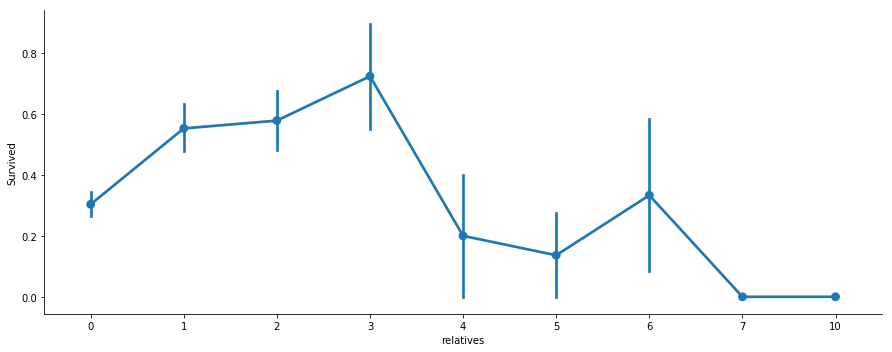

In [15]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

People with 1 to 3 relatives have the best chance of survival. Chances are close to null for people with more thsan 6 relatives.

# Data processing

'PassengerId' has no contribution to survival probability, so we can drop it from the training set.

In [16]:
train_df = train_df.drop(['PassengerId'], axis=1)

### Missing data
'Cabin', 'Age' and 'Embarked' present some missing values. 

The 'Cabin' feature contains numbers and a letter which refers to the Deck. We can extract the person's Deck, convert it to a purely numeric value and assign a value of zero to the missing values. Deck, in the case of Titanic, ranges from A to G.

In [17]:
import re #https://docs.python.org/3/howto/regex.html for an overview of Regular Expression

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 

We can remove the cabin feature, as we'll be using the Deck feature instead from now on.

In [18]:
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

The feature 'Age' has some missing values that we can handle by generating numbers based on the mean and standard deviation over the sample.

In [19]:
data = [train_df, test_df]

for dataset in data:
    mean = dataset["Age"].mean()
    std = dataset["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

For 'Embarked' we can simply insert the most common value, since there are only two missing values. First let's check what is the top value:

In [20]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [21]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

## Transforming features
Let's take a look again at our data types:

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null int64
SibSp        891 non-null int64
Parch        891 non-null int64
Ticket       891 non-null object
Fare         891 non-null float64
Embarked     891 non-null object
relatives    891 non-null int64
alone        891 non-null int64
Deck         891 non-null int64
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


We must deal with the float feature 'Fare' and the four categorical features 'Name', 'Sex', 'Ticket' and 'Embarked'. 

Let's start with 'Fare' by simply converting it into int64.

In [23]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

For 'Name' we can extract the title and create a new numeric feature based on that. Let's attribute all the non-standard titles to 'Rare', create a dictionary and map the categorical feature into numerical. After this transformation we can drop the 'Name' feature.

In [24]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    # replace some different spelling
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
   
    # map titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    
    # fill any NaN with 0
    dataset['Title'] = dataset['Title'].fillna(0)
    
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

The transformation of the 'Sex' feature is easy; let's define male = 0 and female = 1:

In [25]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

'Embarked' feature can also be easily mapped into numeric:

In [26]:
port = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(port)

The 'ticket' feature is more complex:

In [27]:
train_df['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

'Ticket' has 681 unique values, which gives us a hard time in converting it to meaningfull categories. And we can expect that this feature has no strong correlation with the survival probability, so we drop it:

In [28]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

## Synthetic features

Here we add new features, created by bucketing and crossing the input features.
'Age' and 'Fare' are bucket into 7 and 6 groups respectively.

In [29]:
train_df['GroupAge'], bins = pd.qcut(train_df['Age'], 7, retbins=True, labels=False)
test_df['GroupAge'] = pd.cut(test_df['Age'], bins=bins, labels=False, include_lowest=True)

print(train_df[['GroupAge', 'Survived']].groupby(['GroupAge'], as_index=False).mean())

#print(train_df['GroupAge']).value_counts()
#print(test_df['GroupAge']).value_counts()

   GroupAge  Survived
0         0  0.496183
1         1  0.308725
2         2  0.359649
3         3  0.375000
4         4  0.418033
5         5  0.366412
6         6  0.370968


In [30]:
train_df['GroupFare'], bins2 = pd.qcut(train_df['Fare'], 6, retbins=True, labels=False) # binning based on the quantiles
test_df['GroupFare'] = pd.cut(test_df['Fare'], bins = bins2, labels=False, include_lowest=True) # using the binning from the training set

print (train_df[['GroupFare', 'Survived']].groupby(['GroupFare'], as_index=False).mean())
#print(train_df['GroupFare'].value_counts())
#print(test_df['GroupFare'].value_counts())

   GroupFare  Survived
0          0  0.215768
1          1  0.142857
2          2  0.356164
3          3  0.484848
4          4  0.382114
5          5  0.691781


Let's create a 'Fare per person' feature:

In [31]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

And let's have a look at our training set, after working on the features:

In [32]:
train_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,alone,Deck,Title,GroupAge,GroupFare
0,0,3,0,22,1,0,7,0,1,0,8,1,1,0
1,1,1,1,38,1,0,71,1,1,0,3,3,5,5
2,1,3,1,26,0,0,7,0,0,1,8,2,2,0
3,1,1,1,35,1,0,53,0,1,0,3,3,4,5
4,0,3,0,35,0,0,8,0,0,1,8,1,4,1


In [33]:
X_train = train_df.drop(["Survived", "Fare", "Age"], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(["PassengerId", "Fare", "Age"], axis=1).copy()

# Models

Time to implement Machine Learning methods! For this purpose I will use different Scikit-learn methods. 

In [34]:
# First scale the data

scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  

(41.32, '%')


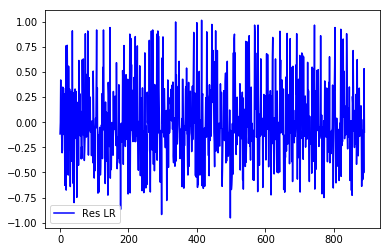

In [35]:
# Linear Regression
ols = LinearRegression(fit_intercept=True, normalize=False)
LR = ols.fit(X_train,Y_train)

Res_LR = Y_train.values - LR.predict(X_train) #Residuals 

acc_ols = round(ols.score(X_train, Y_train) * 100, 2)
print(round(acc_ols,2,), "%")

plt.plot(np.arange(0,len(X_train)),Res_LR,color='b')
_=plt.legend(['Res LR', 'Res BGD'])

In [36]:
# stochastic gradient descent (SGD)
sgd = SGDClassifier(loss="hinge", max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

print(round(acc_sgd,2,), "%")

(72.84, '%')


In [37]:
# Minibatch gradient descent
classes = np.unique(Y_train) 

MBgd = SGDClassifier(loss="hinge", max_iter=5, tol=None)
MBgd.partial_fit(X_train, Y_train, classes = classes)
Y_pred = MBgd.predict(X_test)

acc_MBgd = round(MBgd.score(X_train, Y_train) * 100, 2)

print(round(acc_MBgd,2,), "%")

(75.31, '%')


In [38]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(round(acc_log,2,), "%")


(81.93, '%')


In [39]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

(93.27, '%')


In [40]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

(93.27, '%')


In [41]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(round(acc_knn,2,), "%")


(85.97, '%')


In [42]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(round(acc_gaussian,2,), "%")


(78.68, '%')


In [43]:
# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(round(acc_perceptron,2,), "%")

(75.87, '%')


In [44]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(round(acc_linear_svc,2,), "%")

(81.37, '%')


#### Let's compare the different models:

In [45]:
results = pd.DataFrame({
    'Model': ["Linear Regression", 'Stochastic Gradient Decent',
              'Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Decision Tree', 'Naive Bayes', 'Perceptron'],
    'Score': [acc_ols, acc_sgd, acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_decision_tree, acc_gaussian, acc_perceptron]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(10)

,Model
Score,
93.27,Random Forest
93.27,Decision Tree
85.97,KNN
81.93,Logistic Regression
81.37,Support Vector Machines
78.68,Naive Bayes
75.87,Perceptron
72.84,Stochastic Gradient Decent
41.32,Linear Regression


Apparently Random Forest (and Decision Tree) provides our best model. Let's move one step further and test how well this methods performs on a cross-validation.

With Sklearn we can perform cross validation using cross_val_score, which is based on the Kfold method. This method will train the model K times, using a diferent Kth folder on each iteraction as validation set and the remaining K-1 folders as training sets.

In [46]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=15, scoring = "accuracy") # cv is the number of folds we want to use

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

('Scores:', array([0.76666667, 0.81666667, 0.86666667, 0.76666667, 0.76666667,
       0.85      , 0.88333333, 0.83333333, 0.83333333, 0.79661017,
       0.81355932, 0.79661017, 0.82758621, 0.82758621, 0.84482759]))
('Mean:', 0.8193408662900189)
('Standard Deviation:', 0.03449592518185609)


In fact our Random Forest model has a mean score of ~0.81 and standard deviation of 0.04.

We can work further on our Random Forest model and try to improve the performance, for example by tunning hyperparameters and checking feature importance.

### Feature importance with Random Forest

In [47]:
X_train = train_df.drop(["Survived", "Fare", "Age"], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(["PassengerId", "Fare", "Age"], axis=1).copy()

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [48]:
importances.head(15)

,importance
feature,
Sex,0.200
Title,0.172
GroupAge,0.150
GroupFare,0.111
Deck,0.095
Pclass,0.084
relatives,0.063
Embarked,0.044
SibSp,0.042


#### Now let's try XGBoost

One thing to note is that the test sample doesn't have a target variable. So let's split the train set to be able to cross validate our model.

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.20)

In [60]:
xgb_model = XGBClassifier(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10)

eval_set = [(X_train, Y_train), (X_test, Y_test)]
eval_metric = ["auc","error"]
%time xgb_model.fit(X_train, Y_train, early_stopping_rounds=10, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 22.2 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [80]:
# evaluate predictions
predictions_train = xgb_model.predict(X_train)
predictions_test = xgb_model.predict(X_test)

print("Accuracy (Train): %.3f%%" % (metrics.accuracy_score(Y_train, predictions_train)*100))
print("Accuracy (Test): %.3f%%" % (metrics.accuracy_score(Y_test, predictions_test)*100))
print("AUC Score (Train): %.3f" % metrics.roc_auc_score(Y_train, predictions_train))
print("AUC Score (Test): %.3f" % metrics.roc_auc_score(Y_test, predictions_test))
print("Mean Square Error (Train): %.3f" % metrics.mean_squared_error(Y_train, predictions_train))
print("Mean Square Error (Test): %.3f" % metrics.mean_squared_error(Y_test, predictions_test))

Accuracy (Train): 81.180%
Accuracy (Test): 80.447%
AUC Score (Train): 0.794
AUC Score (Test): 0.778
Mean Square Error (Train): 0.188
Mean Square Error (Test): 0.196


Let's also try a Kfold CV. First redefine our train set using the full sample:

In [ ]:
Xtrain = train_df.drop(["Survived", "Fare", "Age"], axis=1)
Ytrain = train_df["Survived"]

In [55]:
# this function can be reused 
def modelfit(alg, Xtrain, Ytrain, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(Xtrain.values, label=Ytrain.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(Xtrain, Ytrain, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(Xtrain)
    dtrain_predprob = alg.predict_proba(Xtrain)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.2f" % metrics.accuracy_score(Ytrain, dtrain_predictions)
    print "AUC Score (Train): %.2f" % metrics.roc_auc_score(Ytrain, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.84
AUC Score (Train): 0.88


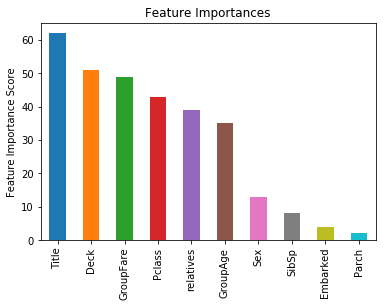

In [56]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=500,
 max_depth=3,
 min_child_weight=1,
 gamma=0.5,
 subsample=0.8,
 colsample_bytree=0.4,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, Xtrain, Ytrain)

A second model using Kfold CV:

In [74]:
# CV model
model_xgbKfold = XGBClassifier(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=1)

kfold = StratifiedKFold(n_splits=10, random_state=7)

model_xgbKfold.fit(Xtrain, Ytrain)

predictions_Ytrain = model_xgbKfold.predict(Xtrain)
results = cross_val_score(model_xgbKfold, Xtrain, Ytrain, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("AUC Score: %.2f" % metrics.roc_auc_score(Ytrain, predictions_Ytrain))

Accuracy: 83.16% (3.33%)
AUC Score: 0.83


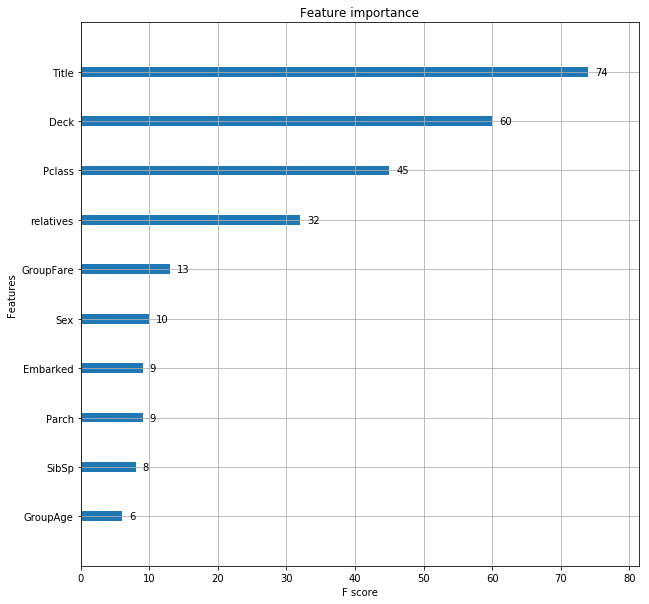

In [443]:
data_dmatrix = xgb.DMatrix(data=Xtrain,label=Ytrain)

params = {'silent':True, 'colsample_bytree': 0.8,'learning_rate': 0.01,
                'max_depth': 3, 'alpha': 10}
xg_ = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50)

xgb.plot_importance(xg_)
plt.rcParams['figure.figsize'] = [10, 10];

The most important features differ between the Random Forest and XGBoost models. This could be due to the lack of accuracy/precision in estimating the feature attribution. One possible way to tackle this issue is try to check the SHAP values.

Finally, let's try an emsemble model. Note that ensembles are prime candidates for parallelization, and it is critical to leverage this capability to the greatest extent possible.